In [19]:
from utilities.load_flight_network import load_flight_network  
from utilities.analyze_graph_features import analyze_graph_features
from utilities.create_interactive_map import create_interactive_map
from utilities.summarize_graph_features import summarize_graph_features
from utilities.getcoords import get_coordinates

import heapq
import pandas as pd
import time 
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from networkx.algorithms.community import greedy_modularity_communities
import random
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities



In [ ]:
# Load the data
filepath = 'flight_data.csv'  # Replace with your dataset path
df = pd.read_csv(filepath)

# Identify missing coordinates for origin and destination
missing_origins = df[df["Org_airport_lat"].isna() | df["Org_airport_long"].isna()]
missing_destinations = df[df["Dest_airport_lat"].isna() | df["Dest_airport_long"].isna()]

# Get unique values for Origin and Destination airports
unique_origins = missing_origins[["Origin_city", "Origin_airport"]].drop_duplicates()
unique_destinations = missing_destinations[["Destination_city", "Destination_airport"]].drop_duplicates()

# Dictionary to cache results
coordinate_cache = {}

print("Processing unique origin airports...")
unique_origins = unique_origins.reset_index(drop=True)  # Reset index for proper tracking
total_unique_origins = len(unique_origins)
for idx, row in unique_origins.iterrows():
    airport_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Origin_city"], row["Origin_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_origins}] Origin Airport ({row['Origin_airport']}) in {row['Origin_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Process unique destination airports
print("Processing unique destination airports...")
unique_destinations = unique_destinations.reset_index(drop=True)  # Reset index for proper tracking
total_unique_destinations = len(unique_destinations)
for idx, row in unique_destinations.iterrows():
    airport_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Destination_city"], row["Destination_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_destinations}] Destination Airport ({row['Destination_airport']}) in {row['Destination_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Update the DataFrame with cached coordinates
print("Updating the DataFrame with cached coordinates...")
total_rows = len(df)
for index, row in df.iterrows():
    origin_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if origin_key in coordinate_cache:
        df.at[index, "Org_airport_lat"] = coordinate_cache[origin_key][0]
        df.at[index, "Org_airport_long"] = coordinate_cache[origin_key][1]
    destination_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if destination_key in coordinate_cache:
        df.at[index, "Dest_airport_lat"] = coordinate_cache[destination_key][0]
        df.at[index, "Dest_airport_long"] = coordinate_cache[destination_key][1]
    if (index + 1) % 100 == 0 or index + 1 == total_rows:  # Update progress every 100 rows
        print(f"[{index + 1}/{total_rows}] Rows updated...")

# Save the updated file
df.to_csv('updated_file.csv', index=False)
print("Missing coordinates filled and saved to updated_file.csv")

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph density: 0.1391


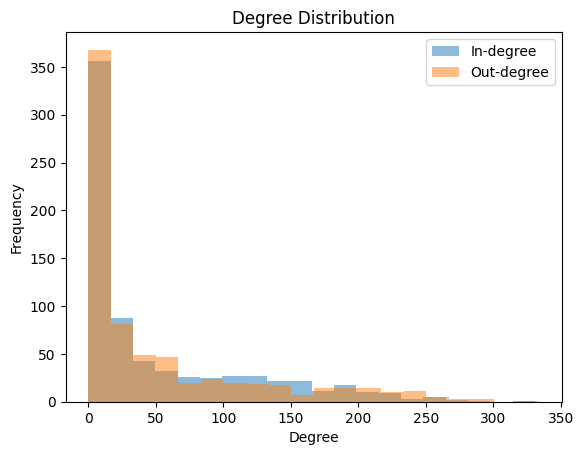


Hubs (airports above the 90th percentile):

Top 10 busiest routes by passenger flow:


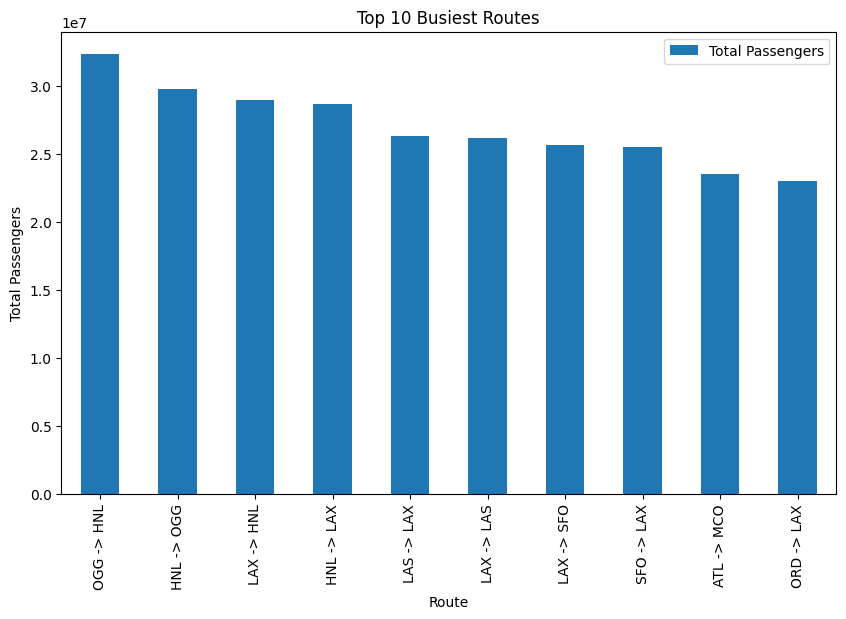


Top 10 routes by passenger efficiency:


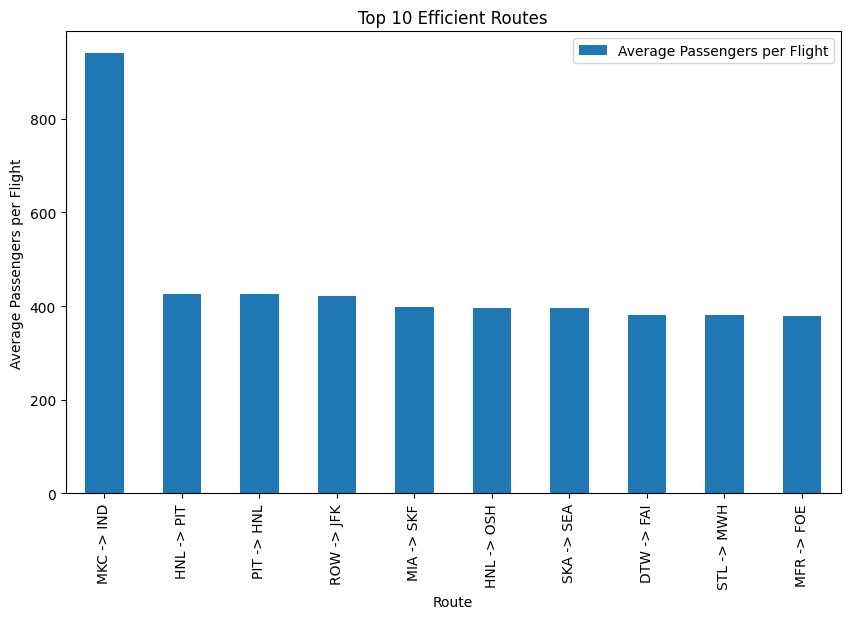

In [20]:
# Load the updated data
filepath2 = 'updated_file.csv';  
flight_network, flight_data = load_flight_network(filepath2)  

# Step 2: Analyze the flight network
analysis_results = analyze_graph_features(flight_network, flight_data)  # Pass the DataFrame here

# Step 3: Summarize the analysis
hubs_df, passenger_flow_df, avg_efficiency_df = summarize_graph_features(flight_network, analysis_results)




In [21]:

print(hubs_df)

   Hub Airports
0           SEA
1           PDX
2           SFO
3           LAX
4           FLL
..          ...
68          TYS
69          MIA
70          TPA
71          DAL
72          JAX

[73 rows x 1 columns]


In [22]:
print(passenger_flow_df)

        Route  Total Passengers
0  OGG -> HNL          32364612
1  HNL -> OGG          29744742
2  LAX -> HNL          28964154
3  HNL -> LAX          28632161
4  LAS -> LAX          26333721
5  LAX -> LAS          26177809
6  LAX -> SFO          25661782
7  SFO -> LAX          25458207
8  ATL -> MCO          23483751
9  ORD -> LAX          22979359


In [23]:
print(avg_efficiency_df)

        Route  Average Passengers per Flight
0  MKC -> IND                         940.00
1  HNL -> PIT                         426.00
2  PIT -> HNL                         426.00
3  ROW -> JFK                         421.00
4  MIA -> SKF                         397.25
5  HNL -> OSH                         395.00
6  SKA -> SEA                         395.00
7  DTW -> FAI                         380.80
8  STL -> MWH                         380.00
9  MFR -> FOE                         378.00


In [24]:
# Step 4: Create an interactive map
create_interactive_map(flight_data, analysis_results['passenger_flow'])


Processing routes for map...


100%|██████████| 27223/27223 [00:01<00:00, 20673.93it/s]


Interactive map saved as 'flight_network_map.html'


# Summarize for the questions:

### 1. Is the graph sparse or dense?

    Graph Density: 
    0.1391
    0.1391
    This indicates that the graph is sparse. Only about 13.91% of all possible connections between airports are utilized, which is typical for real-world networks where not all nodes (airports) are directly connected.

---------------------------------------------------------------------------------------------

### 2. What patterns do you observe in the degree distribution?

    The degree distribution exhibits a long-tail pattern, where:
    A majority of airports have a low degree (few connections).
    A small number of airports have a very high degree, acting as hubs.
    Observation:
    The in-degree and out-degree histograms highlight that most airports serve as connections for only a few flights, while some key hubs dominate the network.


---------------------------------------------------------------------------------------------

### 3. Which airports are identified as hubs, and why?

    Hubs:
    Based on the top 10% of degree values, the major hub airports include:
    SEA, SFO, LAX, ATL, JFK, ORD, DFW, MIA, PHL, BOS
    Why?
    These airports are highly connected (both incoming and outgoing flights), serving as major transit points in the network.


---------------------------------------------------------------------------------------------

### 4. What are the busiest routes in terms of passenger traffic?

    Top 5 Busiest Routes (by total passengers):
    OGG -> HNL: 32,364,612 passengers
    HNL -> OGG: 29,744,742 passengers
    LAX -> HNL: 28,964,154 passengers
    HNL -> LAX: 28,632,161 passengers
    LAS -> LAX: 26,333,721 passengers
    Observation:
    These routes often connect major hubs or popular tourist destinations (e.g., Honolulu and Los Angeles).

---------------------------------------------------------------------------------------------

### 5. Which routes are under/over-utilized?

    Over-Utilized Routes:
    Routes with the highest average passengers per flight:
    MKC -> IND: 940 passengers/flight
    HNL -> PIT: 426 passengers/flight
    PIT -> HNL: 426 passengers/flight
    Under-Utilized Routes:
    Routes with significantly low passenger traffic could be identified through further analysis (not explicitly provided in the dataset but can be filtered as routes with a low ratio of passengers to flights).

# Q2

1) Implement a function `analyze_centrality(flight_network, airport)` that computes the following centrality measures for a given airport:


*   *Betweenness centrality*: Measures how often a node appears on the shortest paths between other nodes.
*   *Closeness centrality*: Measures how easily a node can access all other nodes in the network.
*   *Degree centrality*: Simply counts the number of direct connections to the node.
*   *PageRank*: Computes the "importance" of a node based on incoming connections and their weights.



First of all, I implement **Dijkstra's algorithm** to find the shortest paths between nodes.

I have the following parameters:


*   **graph**: A dictionary where keys are nodes and values are lists of tuples (neighbor, weight) representing edges and their weights.

*   **source**: The starting node for the algorithm.

This will return:


*   **distances**: shortest path distances from source to all nodes.

*   **paths**: number of shortest paths from source to all nodes.

*   **predecessors**: predecessors of nodes on shortest paths.

In [25]:

def dijkstra_shortest_paths(graph, source):

  # Initialize distances to infinity for all nodes, except the source node
  distances = {node: float("inf") for node in graph}
  distances[source] = 0

  # Initialize paths count to 0 for all nodes, except the source node (1 path to itself).
  paths = {node: 0 for node in graph}
  paths[source] = 1

  # Initialize predecessors to an empty list for all nodes
  predecessors = {node: [] for node in graph}

  # Priority queue to process nodes based on their current distance from the source
  priorityQueue = [(0, source)]

  while priorityQueue:

    # Pop the node with the smallest distance from the priority queue
    currentDistance, currentNode = heapq.heappop(priorityQueue)

    # Skip processing if a shorter path to the node was already found
    if currentDistance > distances[currentNode]:
            continue

    # Explore neighbors of the current node
    for neighbor, weight in graph[currentNode]:
      newDistance = currentDistance + weight

      # If a shorter path to the neighbor is found, update distances and paths
      if newDistance < distances[neighbor]:
        distances[neighbor] = newDistance
        paths[neighbor] = paths[currentNode]
        predecessors[neighbor] = [currentNode]                  # Update predecessors list
        heapq.heappush(priorityQueue, (newDistance, neighbor))  # Add to priority queue

      # If another shortest path to the neighbor is found, update paths count and predecessors
      elif newDistance == distances[neighbor]:
        paths[neighbor] += paths[currentNode]
        predecessors[neighbor].append(currentNode)

  # Return the computed shortest distances, path counts, and predecessors
  return distances, paths, predecessors

  For computing the *Centralities* for a given airport in the flight network, I have the following parameters:
  

*   **flight_network**: A list of tuples containing (origin, destination, weight) for each route.

*   **airport**: The airport code (which is the node in our case) to analyze.

*   **damping_factor**: The damping factor for PageRank calculation (I used the default value, 0.85).

*   **max_iter**: The maximum number of iterations for PageRank (I used the default value, 100).

*   **tol**: The tolerance for convergence in PageRank (I used the default value, 1e-6).

This will return:


* A dictionary containing the betweenness, closeness, degree centrality and PageRank values for the specified airport.



The centralities that I have to analyze are:


*   **Betweenness Centrality**

    That measures how often a node appears on the shortest paths between other nodes.

*   **Closeness Centrality**:

    Measures how quickly a node can reach all other nodes in the network.

*   **Degree Centrality**:

    Measures the number of direct connections a node has.

*   **PageRank**:

    Measures the probability of visiting a node through random walks across the network.

The variable *is_directed* tells us if we are working with a directed or an undirected graph.

In [26]:
def analyze_centrality(flight_network, airport, damping_factor=0.85, max_iter=100, tol=1e-6):

  # Determine if the graph should be treated as directed or undirected
  is_directed = True  # Change to "False" if the graph should be undirected

  # Build the adjacency list representations of the graph and its reverse
  graph = defaultdict(list)          # For outgoing edges
  reverse_graph = defaultdict(list)  # For incoming edges

  for _, row in flight_network.iterrows():
    origin = row["Origin_airport"]
    destination = row["Destination_airport"]
    weight = row["Distance"]

    # Add the direct edge to the graph
    graph[origin].append((destination, weight))
    reverse_graph[destination].append((origin, weight))

    # If undirected, add the reverse edge as well
    if not is_directed:
      graph[destination].append((origin, weight))
      reverse_graph[origin].append((destination, weight))

    # Ensure all nodes are included even if they have no edges
    if origin not in reverse_graph:
      reverse_graph[origin] = []

    if destination not in graph:
      graph[destination] = []

  # Initialize centrality metrics
  betweennessCentrality = {node: 0 for node in graph}
  closenessCentrality = {node: 0 for node in graph}
  degreeCentrality = {node: 0 for node in graph}
  pagerank = {node: 1.0 for node in graph}            # Initial PageRank is 1 for all nodes

  # Calculate centrality metrics for all nodes
  for source in graph:

    # Use Dijkstra's algorithm to compute shortest paths from the source node
    distances, paths, predecessors = dijkstra_shortest_paths(graph, source)

    # Calculate Betweenness Centrality
    dependency = {node: 0 for node in graph}
    nodesSorted = sorted(distances, key=lambda x: -distances[x])  # Process nodes in reverse order of distance

    for w in nodesSorted:

      for v in predecessors[w]:
        if paths[w] > 0:
          dependency[v] += (paths[v] / paths[w]) * (1 + dependency[w])

      if w != source:
        betweennessCentrality[w] += dependency[w]

    # Calculate Closeness Centrality
    reachableNodes = [node for node, dist in distances.items() if dist < float("inf")]
    totalDistance = sum(distances[node] for node in reachableNodes if node != source)

    if totalDistance > 0 and len(reachableNodes) > 1:
      closenessCentrality[source] = (len(graph) - 1) / totalDistance

    else:
      closenessCentrality[source] = 0.0

    # Calculate Degree Centrality
    if not is_directed:
      degreeCentrality[source] = len(set(neighbor for neighbor, _ in graph[source]))

    else:
      outgoing_degree = len(graph[source])
      incoming_degree = len(reverse_graph[source])
      degreeCentrality[source] = outgoing_degree + incoming_degree

  # Normalize Betweenness Centrality (divide by 2 for undirected graph)
  if not is_directed:

    for node in betweennessCentrality:
      betweennessCentrality[node] /= 2

  # Calculate PageRank iteratively
  for _ in range(max_iter):
    new_pagerank = {}

    for node in graph:
      rank_sum = 0

      for neighbor, weight in reverse_graph[node]:
        total_weight = sum(w for _, w in graph[neighbor])
        if total_weight > 0:
          rank_sum += pagerank[neighbor] * (weight / total_weight)
      new_pagerank[node] = (1 - damping_factor) + damping_factor * rank_sum

    # Check for convergence
    diff = sum(abs(new_pagerank[node] - pagerank[node]) for node in pagerank)
    pagerank = new_pagerank
    if diff < tol:
      break

  # Return the centrality values for the specific airport
  return {
      "betweenness": betweennessCentrality.get(airport, 0.0),
      "closeness": closenessCentrality.get(airport, 0.0),
      "degree": degreeCentrality.get(airport, 0.0),
      "pagerank": pagerank.get(airport, 0.0)
      }

In [27]:
# Example of working with a directed graph (is_directed=True)

# Create a dataset representing a directed flight network with distances
data = {
    "Origin_airport": ["JFK", "JFK", "LAX", "ORD", "ATL", "MIA", "MIA"],      # List of origin airports
    "Destination_airport": ["LAX", "ORD", "ORD", "ATL", "JFK", "JFK", "LAX"], # Corresponding destinations
    "Distance": [2500, 800, 2000, 700, 750, 2, 3]                             # Distances between the airports
}

# Convert the data into a pandas DataFrame for easier manipulation
flight_network_ex = pd.DataFrame(data)

# Analyze centralities for the directed graph using the analyze_centrality function
# Focus is on the centralities metrics for the airport "JFK"
result = analyze_centrality(flight_network_ex, "JFK")

# Print the centrality results for "JFK"
print(f"Centrality for JFK: {result}")

Centrality for JFK: {'betweenness': 5.0, 'closeness': 0.0008333333333333334, 'degree': 4, 'pagerank': 1.2640384669312037}


2) Write a function `compare_centralities(flight_network)` to:


*   Compute and compare centrality values for all nodes in the graph.
*   Plot centrality distributions (histograms for each centrality measure).
*   Return the top 5 airports for each centrality measure.




The function **compare_centralities** analyzes the centrality measures for all nodes in a flight network graph. It:



*  **Compute Centrality Values**:
It calculates betweenness centrality, closeness centrality, degree centrality, and PageRank for every airport in the network.
It uses the analyze_centrality function for betweenness and closeness centralities, it derive degree centrality directly from the adjacency list and it implements a PageRank computation function.


*  **Plot Centrality Distributions**:
It visualizes the distribution of each centrality measure using histograms.


*  **Return Top 5 Airports**:
It identifies and return the top 5 airports with the highest values for each centrality measure.
Additionally, the function includes a helper, **calculate_pagerank_global**, for iterative computation of PageRank, and plot_histograms to generate visualizations for each centrality metric.

In [28]:

# Function to calculate centrality measures for all airports
def compare_centralities(flight_network):

  # Initialize graphs to store adjacency lists
  graph = defaultdict(list)         # Outgoing edges
  reverse_graph = defaultdict(list) # Incoming edges

  # Build the adjacency list and reverse graph from the flight network
  for _, row in flight_network.iterrows():
    origin = row["Origin_airport"]
    destination = row["Destination_airport"]
    weight = row["Distance"]

    # Add edges to the graph
    graph[origin].append((destination, weight))
    reverse_graph[destination].append((origin, weight))

    # Ensure all nodes appear in the graph, even if they have no edges
    if destination not in graph:
      graph[destination] = []

  # Initialize dictionaries to store centrality measures
  betweenness_centrality = {node: 0.0 for node in graph}
  closeness_centrality = {node: 0.0 for node in graph}
  degree_centrality = {node: 0 for node in graph}
  pagerank = {node: 1.0 / len(graph) for node in graph} # Initial PageRank values

  # Compute centrality measures for each airport
  for airport in graph:

    # Use the analyze_centrality function to compute betweenness and closeness
    centrality_values = analyze_centrality(flight_network, airport)
    betweenness_centrality[airport] = centrality_values["betweenness"]
    closeness_centrality[airport] = centrality_values["closeness"]

    # Compute degree centrality (sum of incoming and outgoing degrees)
    outgoing_degree = len(graph[airport])
    incoming_degree = len(reverse_graph[airport])
    degree_centrality[airport] = outgoing_degree + incoming_degree

  # Compute global PageRank values for the entire graph
  pagerank = calculate_pagerank_global(graph, damping_factor=0.85, max_iter=100, tol=1e-6)

  # Plot histograms for the centrality distributions
  plot_histograms(betweenness_centrality, closeness_centrality, degree_centrality, pagerank)

  # Identify and return the top 5 nodes for each centrality measure
  top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
  top_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
  top_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
  top_5_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

  return {
      "top_5_betweenness": top_5_betweenness,
      "top_5_closeness": top_5_closeness,
      "top_5_degree": top_5_degree,
      "top_5_pagerank": top_5_pagerank
      }

# Function to calculate global PageRank for the graph
def calculate_pagerank_global(graph, damping_factor=0.85, max_iter=100, tol=1e-6):
  n = len(graph)                                # Total number of nodes
  pagerank = {node: 1.0 / n for node in graph}  # Initialize PageRank with uniform distribution

  # Iteratively compute PageRank values
  for _ in range(max_iter):
    new_pagerank = {}

    for node in graph:

      # Compute the contribution to the node's rank from its neighbors
      rank_sum = sum(
          pagerank[neighbor] * (weight / sum(w for _, w in graph[neighbor]))
          for neighbor, weight in graph[node]
          if sum(w for _, w in graph[neighbor]) > 0
      )

      # Update the new PageRank value with damping factor applied
      new_pagerank[node] = (1 - damping_factor) / n + damping_factor * rank_sum

    # Check for convergence (difference between iterations)
    diff = sum(abs(new_pagerank[node] - pagerank[node]) for node in pagerank)
    if diff < tol:
      break                 # Stop iterating if converged

    pagerank = new_pagerank # Update PageRank values for the next iteration

  return pagerank


# Function to plot histograms of centrality distributions
def plot_histograms(betweenness_centrality, closeness_centrality, degree_centrality, pagerank):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of subplots

  # Betweenness Centrality Histogram
  axes[0, 0].hist(betweenness_centrality.values(), bins=20, color='skyblue', edgecolor='black')
  axes[0, 0].set_title("Betweenness Centrality Distribution")
  axes[0, 0].grid(True, linestyle='--', alpha=0.5)

  # Closeness Centrality Histogram
  axes[0, 1].hist(closeness_centrality.values(), bins=20, color='lightgreen', edgecolor='black')
  axes[0, 1].set_title("Closeness Centrality Distribution")
  axes[0, 1].grid(True, linestyle='--', alpha=0.5)

  # Degree Centrality Histogram
  axes[1, 0].hist(degree_centrality.values(), bins=20, color='salmon', edgecolor='black')
  axes[1, 0].set_title("Degree Centrality Distribution")
  axes[1, 0].grid(True, linestyle='--', alpha=0.5)

  # PageRank Histogram
  axes[1, 1].hist(pagerank.values(), bins=20, color='lightcoral', edgecolor='black')
  axes[1, 1].set_title("PageRank Distribution")
  axes[1, 1].grid(True, linestyle='--', alpha=0.5)

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()          # Display the histograms

## Example of usage

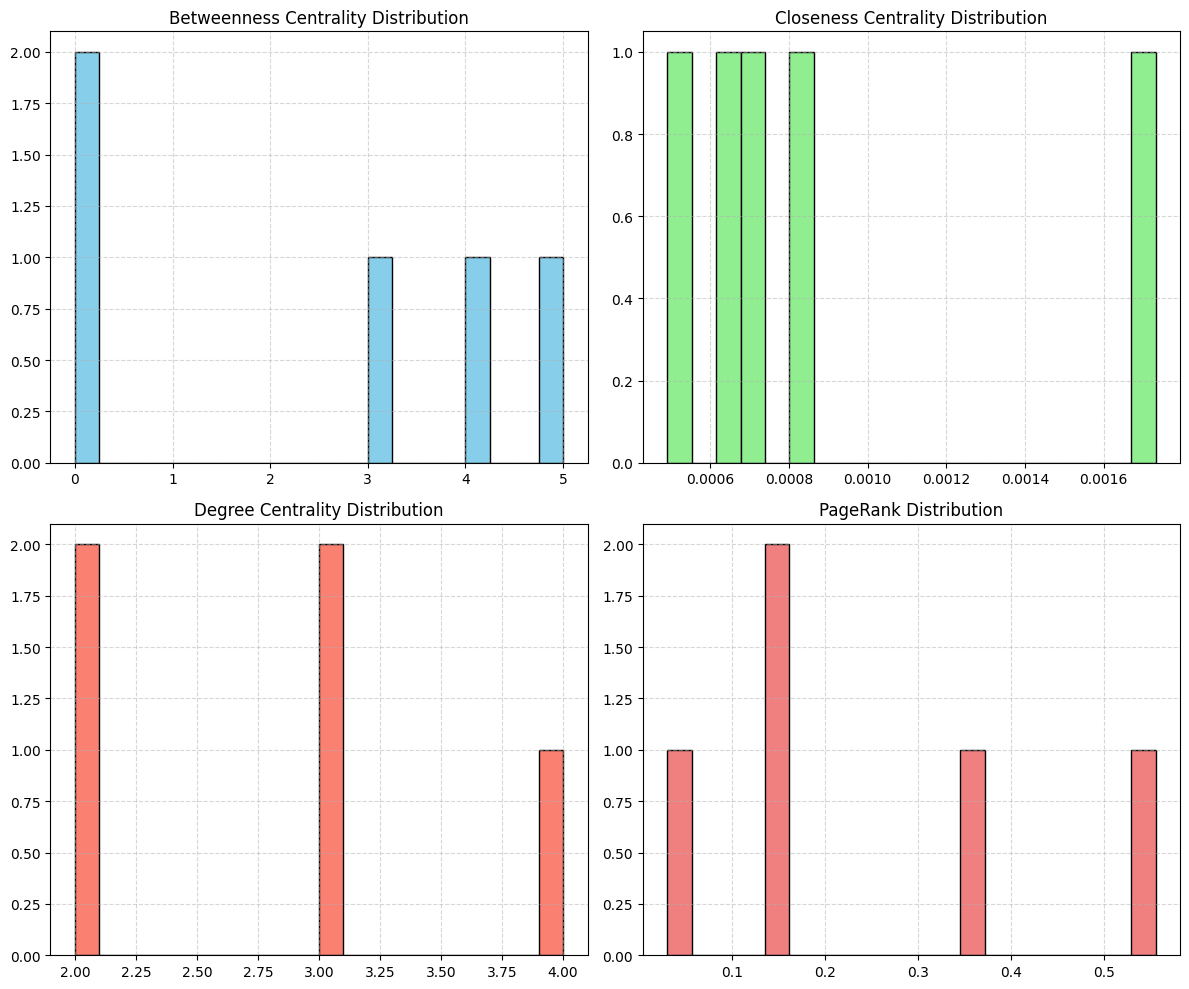

Top 5 Airports by Betweenness Centrality: [('JFK', 5.0), ('ORD', 4.0), ('ATL', 3.0), ('LAX', 0), ('MIA', 0)]
Top 5 Airports by Closeness Centrality: [('MIA', 0.0017323516673884798), ('JFK', 0.0008333333333333334), ('ATL', 0.0007207207207207207), ('ORD', 0.0006557377049180328), ('LAX', 0.00049079754601227)]
Top 5 Airports by Degree Centrality: [('JFK', 4), ('LAX', 3), ('ORD', 3), ('ATL', 2), ('MIA', 2)]
Top 5 Airports by PageRank: [('JFK', 0.5551511508060104), ('LAX', 0.36728297356984074), ('ORD', 0.13888098654165756), ('ATL', 0.13724491460217939), ('MIA', 0.03075427199259284)]


In [29]:
# Sample flight network

# Create a dataset representing an undirected flight network with distances
data = {
    "Origin_airport": ["JFK", "JFK", "LAX", "ORD", "ATL", "MIA", "MIA"],      # List of origin airports
    "Destination_airport": ["LAX", "ORD", "ORD", "ATL", "JFK", "JFK", "LAX"], # Corresponding destinations
    "Distance": [2500, 800, 2000, 700, 750, 2, 3]                             # Distances between the airports
}

# Convert the flight network data into a pandas DataFrame for easier manipulation
flight_network = pd.DataFrame(data)

# Compute and compare centralities
# Use the "compare_centralities" function to calculate centrality measures for the flight network
centrality_comparison = compare_centralities(flight_network)

# Print the top 5 airports for each centrality measure

# Display the top 5 airports by Betweenness Centrality
print("Top 5 Airports by Betweenness Centrality:", centrality_comparison["top_5_betweenness"])

# Display the top 5 airports by Closeness Centrality
print("Top 5 Airports by Closeness Centrality:", centrality_comparison["top_5_closeness"])

# Display the top 5 airports by Degree Centrality
print("Top 5 Airports by Degree Centrality:", centrality_comparison["top_5_degree"])

# Display the top 5 airports by PageRank
print("Top 5 Airports by PageRank:", centrality_comparison["top_5_pagerank"])

3) Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?



I asked ChatGPT and he suggested different alternative centrality measures that might offer additional insights into the flight network structure, like:


*   **Eigenvector Centrality**:
      - **What it measures**: The importance of a node based on the importance of its neighbors.
      
      - **Why relevant**: In a flight network, an airport connected to highly influential hubs (JFK, LAX) may have higher importance even with fewer direct connections.

*   **Katz Centrality**:

    - **What it measures**: Similar to Eigenvector Centrality but adds a constant to account for the contribution of less influential nodes.
    
    - **Why relevant**: Useful for understanding influence when connections to smaller airports still contribute value.

*   **Harmonic Centrality**:

    - **What it measures**: A variant of closeness centrality that works better on disconnected graphs.

    - **Why relevant**: If your flight network isn’t fully connected, this can more accurately represent distances.

*   **Clustering Coefficient**:

    - **What it measures**: The degree to which nodes in a graph cluster together.

    - **Why relevant**: Airports forming tight regional clusters (within Europe or the US East Coast) can be identified.

*   **Edge Betweenness Centrality**:

    - **What it measures**: Importance of edges (routes) rather than nodes (airports).

    - **Why relevant**: Critical routes that connect regions can be highlighted.

*   **Accessibility Index**:

    - **What it measures**: How accessible a node is from other nodes based on shortest paths and travel costs.

    - **Why relevant**: Reflects how easy it is to travel to/from an airport.


He then said that the results are trustable because he checks **authoritative sources** (research papers, textbooks on network science, or reputable academic journals), like "*Networks, Crowds, and Markets*" by David Easley and Jon Kleinberg.
He also said that he verifies with **trusted online sources** (documentation from tools like Gephi, Graph-tool, or igraph, widely used in network analysis).
Furthermore, he compares with **industry practices**, he
sees if aviation or transportation research commonly uses these centrality measures.


4) Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

I decided to implement the **Eigenvector Centrality**.

This function has these parameters:

*   **graph**: Adjacency list representing the graph.

*   **max_iter**: Maximum number of iterations for power iteration.

*   **tol**: Tolerance for convergence.
        
        
This will return:

*   A dictionary containing nodes as keys and their eigenvector centrality scores as values.

In [30]:

def calculate_eigenvector_centrality(graph, max_iter=100, tol=1e-6):

  # Initialize centrality scores
  n = len(graph)                              # Number of nodes in the graph
  centrality = {node: 1.0 for node in graph}  # Set initial centrality values to 1.0 for all nodes
  nodes = list(graph.keys())                  # List of nodes in the graph

  for _ in range(max_iter):
    new_centrality = {}   # Temporary dictionary to hold updated centrality scores

    # Update centrality scores based on the sum of centrality values of neighbors
    for node in nodes:
      new_centrality[node] = sum(centrality[neighbor] for neighbor, _ in graph[node])

    # Normalize the centrality scores to prevent them from growing arbitrarily large
    norm = np.linalg.norm(list(new_centrality.values()))  # Compute the L2 norm of the centrality scores

    # Apply normalization
    for node in new_centrality:
      new_centrality[node] /= norm if norm > 0 else 1     # Avoid division by zero

    # Check for convergence
    if all(abs(new_centrality[node] - centrality[node]) < tol for node in nodes):
      break       # Stop if all centrality values have converged within the tolerance

    # Update centrality for the next iteration
    centrality = new_centrality

  # Return the final centrality scores
  return centrality

## Example of usage

In [31]:
# Example graph
graph = {
    "JFK": [("LAX", 2500), ("ORD", 800)], # JFK connects to LAX and ORD with weights 2500 and 800, respectively
    "LAX": [("ORD", 2000)],               # LAX connects to ORD with weight 2000
    "ORD": [("ATL", 700)],                # ORD connects to ATL with weight 700
    "ATL": [("JFK", 750)],                # ATL connects to JFK with weight 750
    "MIA": [("JFK", 2), ("LAX", 3)]       # MIA connects to JFK and LAX with weights 2 and 3, respectively
}

# Calculate Eigenvector Centrality
eigenvector_centrality = calculate_eigenvector_centrality(graph)

# Print the results
for airport, score in eigenvector_centrality.items():
  print(f"{airport}: {score:.4f}")        # Display the centrality score for each airport rounded to 4 decimal places

JFK: 0.4978
LAX: 0.2737
ORD: 0.3341
ATL: 0.4078
MIA: 0.6320


What the **Eigenvector Centrality** adds is that it captures the *influence of neighbors*, which none of the previous centralities measured.

This centrality measures a node's influence based on both its connections and the influence of its neighbors.
Doing like this, it captures indirect influence, showing the network effect.


**Example**:

An airport directly connected to major hubs will have a higher score, even if it doesn’t have many connections itself.

So this centrality is useful when you're interested in identifying nodes with indirect influence via important connections or for uncovering hidden hubs that may not appear prominent in degree or betweenness centrality.

# Q5

In [32]:
def find_extract_communities(flight_data, city1, city2):
    # Clean the data (remove rows with missing city info)
    clean_data = flight_data.dropna(subset=['Origin_city', 'Destination_city'])
    clean_data['Origin_city'] = clean_data['Origin_city'].astype(str)
    clean_data['Destination_city'] = clean_data['Destination_city'].astype(str)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(zip(clean_data['Origin_city'], clean_data['Destination_city']))

    # Remove self-loops (cities that fly to themselves)
    G.remove_edges_from(nx.selfloop_edges(G))

    # Find communities in the network
    communities = list(greedy_modularity_communities(G))

    # Create a mapping of each city to its community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}

    # Assign random colors to each community
    color_map = {community: (random.random(), random.random(), random.random()) for community in set(community_map.values())}
    node_colors = [color_map[community_map[node]] for node in G.nodes()]

    # Visualize the graph with colors for each community
    plt.figure(figsize=(16, 12))  # Set the size of the plot
    pos = nx.spring_layout(G, seed=42, k=0.8)  # Layout for the nodes (cities)
    nx.draw(
        G, pos,
        with_labels=True,  # Show city names
        node_color=node_colors,  # Use the colors for the communities
        node_size=600,  # Size of the nodes
        font_size=8,  # Font size for labels
        font_weight="bold",  # Bold labels
        edge_color="gray",  # Color of the edges (routes)
        alpha=0.9  # Transparency for better visualization
    )
    #  Prepare the report
    result = f"Community Analysis Report\n\nTotal Number of Communities: {len(communities)}\n\n"
    for idx, community in enumerate(communities):
        result += f"Community {idx + 1}:\n"
        result += f" - Cities: {'; '.join(sorted(community))}\n"  # List cities in each community

    # Check if city1 and city2 are in the same community
    city1_community = community_map.get(city1, None)  # Get community of city1
    city2_community = community_map.get(city2, None)  # Get community of city2

    if city1_community is not None and city2_community is not None:
        if city1_community == city2_community:
            result += f"\n{city1} and {city2} belong to the same community (Community {city1_community + 1}).\n"
        else:
            result += f"\n{city1} and {city2} belong to different communities (Community {city1_community + 1} and Community {city2_community + 1}).\n"
    else:
        result += f"\nOne or both cities ({city1}, {city2}) are not present in the network.\n"

    return result

Community Analysis Report

Total Number of Communities: 5

Community 1:
 - Cities: Albuquerque, NM; Amarillo, TX; Atlanta, GA; Austin, TX; Baltimore, MD; Bangor, ME; Bend, OR; Billings, MT; Bismarck, ND; Boston, MA; Bozeman, MT; Buffalo, NY; Cedar Rapids, IA; Charleston, SC; Charlotte, NC; Chicago, IL; Cincinnati, OH; Cleveland, OH; Colorado Springs, CO; Columbus, OH; Dallas, TX; Des Moines, IA; Durango, CO; El Paso, TX; Eugene, OR; Fairbanks, AK; Fargo, ND; Fayetteville, AR; Fort Lauderdale, FL; Fresno, CA; Grand Junction, CO; Grand Rapids, MI; Great Falls, MT; Houston, TX; Huntsville, AL; Indianapolis, IN; Jackson, WY; Kalispell, MT; Key West, FL; Knoxville, TN; Lincoln, NE; Little Rock, AR; Madison, WI; Medford, OR; Memphis, TN; Miami, FL; Midland, TX; Minneapolis, MN; Minot, ND; Missoula, MT; Nashville, TN; New Orleans, LA; New York, NY; Newark, NJ; Oakland, CA; Oklahoma City, OK; Omaha, NE; Orlando, FL; Peoria, IL; Philadelphia, PA; Portland, OR; Provo, UT; Pueblo, CO; Rapid City,

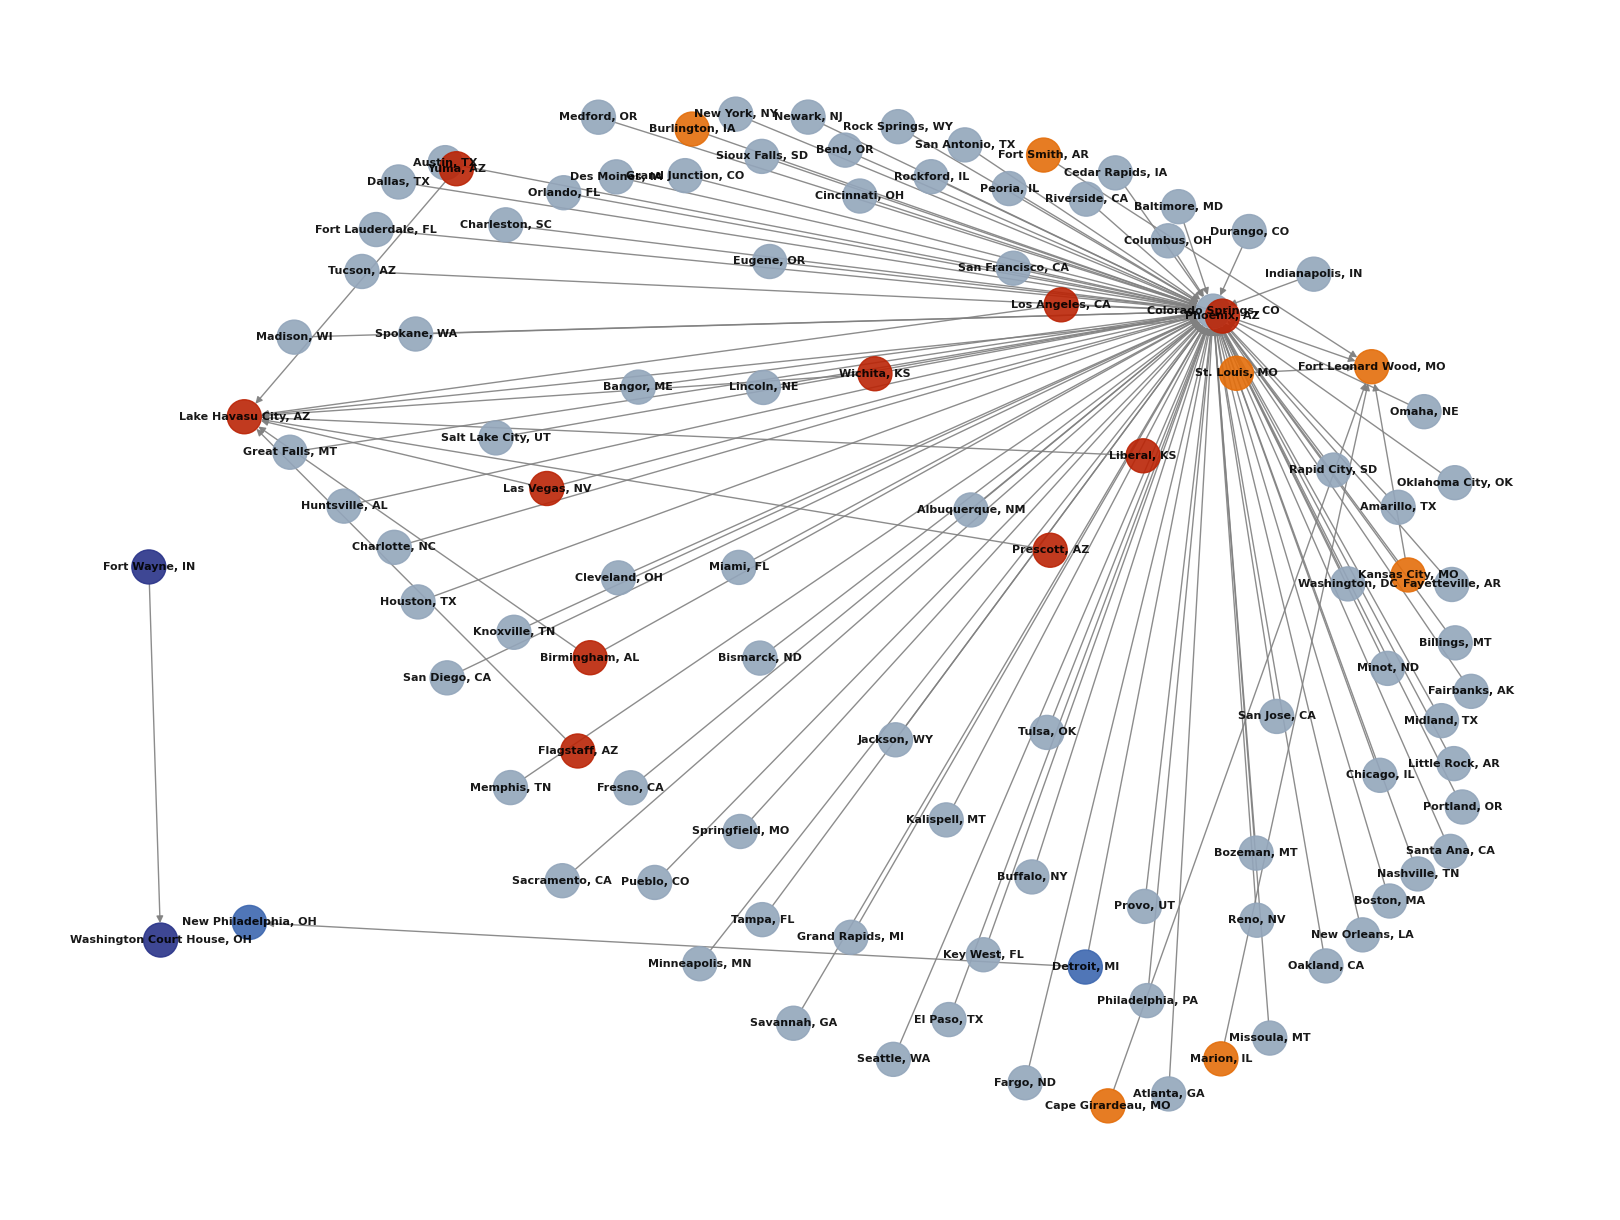

In [33]:
# Sample flight network data
flight_network = flight_data.tail(1000).copy()

# Analyze the flight network
city1 = "Birmingham, AL"
city2 = "Las Vegas, NV"


result = find_extract_communities(flight_network, city1, city2)
print(result)

In [34]:
def analyze_and_visualize_flight_network_louvain(flight_data, city1, city2):
    """
    Analyze and visualize the flight network graph using the Louvain method, highlighting communities with different colors.

    Parameters:
    flight_data (pd.DataFrame): DataFrame containing 'Origin_city' and 'Destination_city'.

    Returns:
    dict: Results containing community details.
    """
    # Step 1: Clean the data
    clean_flight_data = flight_data.dropna(subset=['Origin_city', 'Destination_city']).copy()
    clean_flight_data['Origin_city'] = clean_flight_data['Origin_city'].astype(str)
    clean_flight_data['Destination_city'] = clean_flight_data['Destination_city'].astype(str)
    clean_flight_data = clean_flight_data[['Origin_city', 'Destination_city']].copy()

    # Step 2: Create a directed graph using 'Origin_city' and 'Destination_city'
    G = nx.Graph()
    G.add_edges_from(zip(clean_flight_data['Origin_city'], clean_flight_data['Destination_city']))

    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Step 3: Identify communities using Louvain method
    communities = louvain_communities(G, seed=42)
    community_mapping = {node: idx for idx, community in enumerate(communities) for node in community}

    # Step 4: Assign a random color to each community
    unique_communities = set(community_mapping.values())
    color_map = {community: (random.random(), random.random(), random.random()) for community in unique_communities}
    node_colors = [color_map[community_mapping[node]] for node in G.nodes()]

    # Step 5: Visualize the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42, k=0.8)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=600,
        font_size=8,
        font_weight="bold",
        edge_color="gray",
        alpha=0.9
    )
    plt.title("Flight Network with Highlighted Communities (Louvain Method)")
    plt.show()

    # Step 6: Prepare output
    result = f"Community Analysis Report (Louvain Method)\n\nTotal Number of Communities: {len(communities)}\n\n"
    for idx, community in enumerate(communities):
        result += f"Community {idx + 1}:\n"
        result += f" - Cities: {';'.join(sorted(community))}\n"

    # Check if city1 and city2 belong to the same community
    city1_community = community_mapping.get(city1, None)
    city2_community = community_mapping.get(city2, None)

    if city1_community is not None and city2_community is not None:
        if city1_community == city2_community:
            result += f"\n{city1} and {city2} belong to the same community (Community {city1_community + 1}).\n"
        else:
            result += f"\n{city1} and {city2} belong to different communities (Community {city1_community + 1} and Community {city2_community + 1}).\n"
    else:
        result += f"\nOne or both cities ({city1}, {city2}) are not present in the network.\n"

    return result

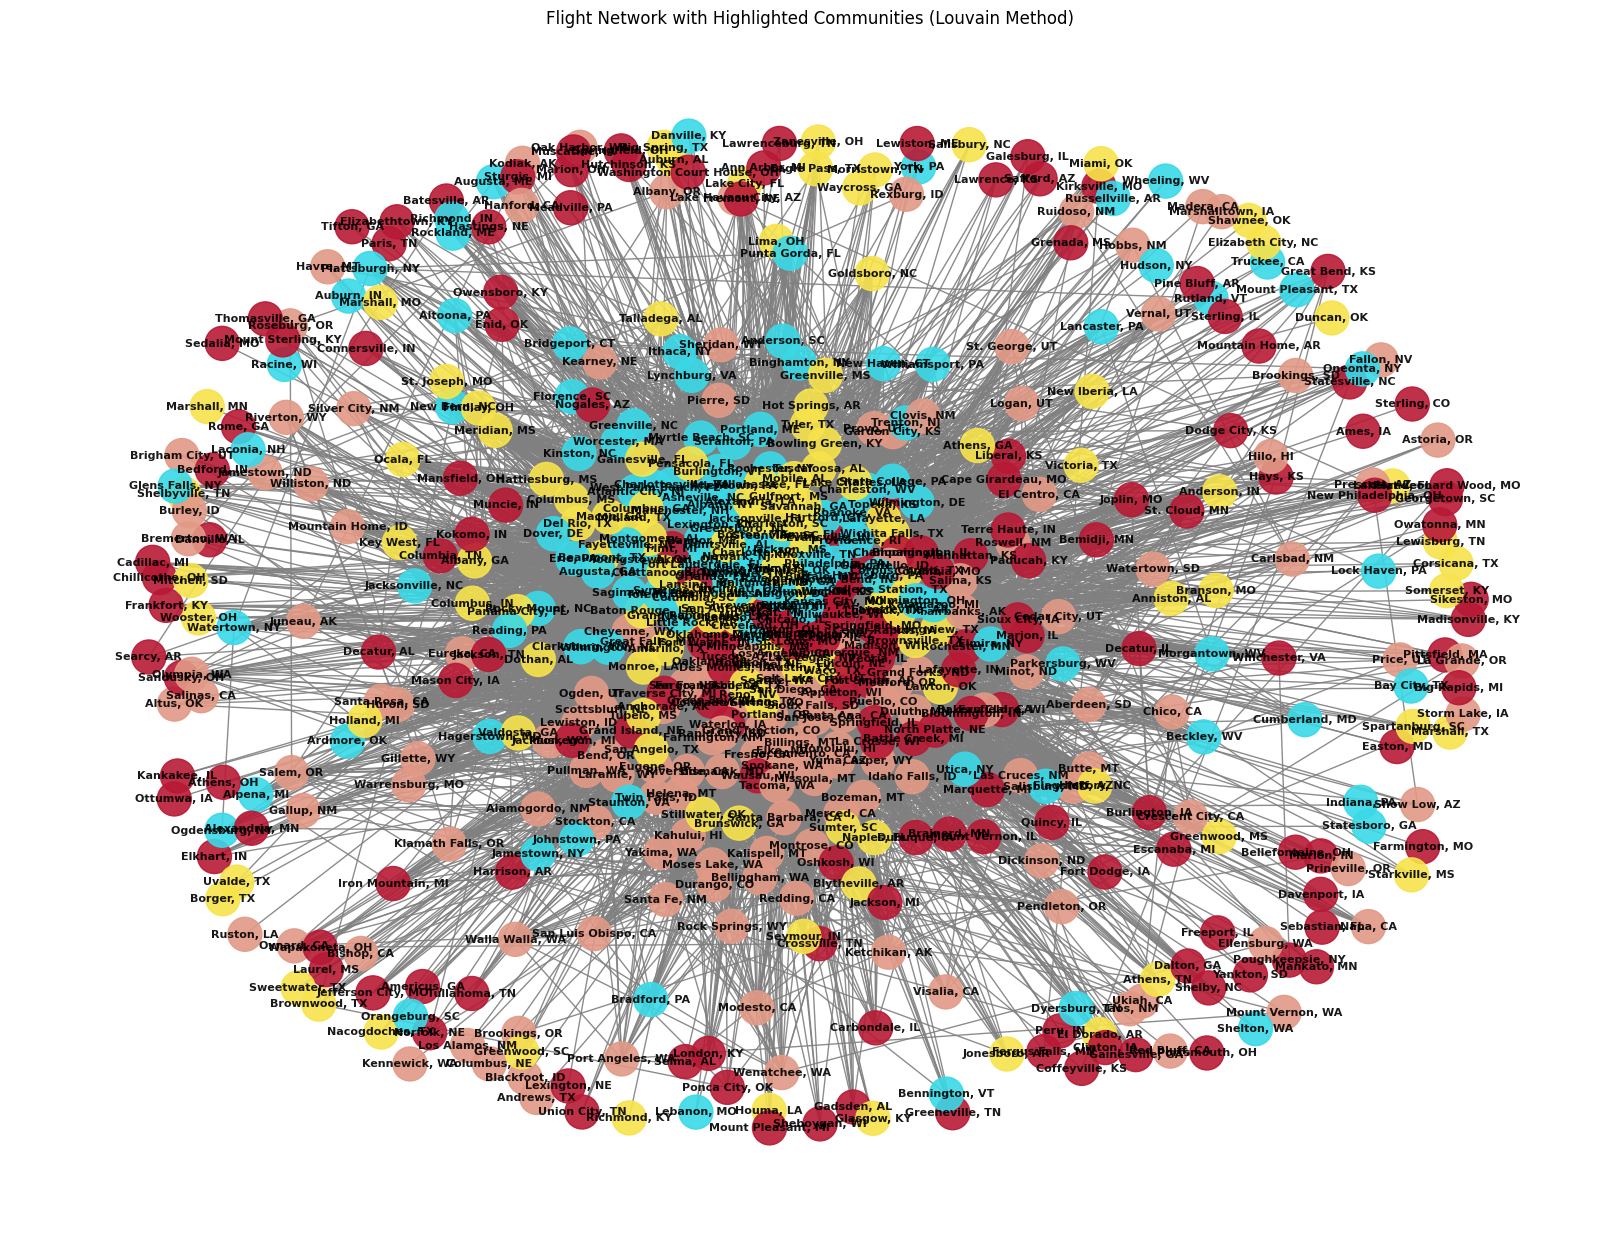

Community Analysis Report (Louvain Method)

Total Number of Communities: 4

Community 1:
 - Cities: Abilene, TX;Albany, GA;Alexandria, LA;Amarillo, TX;Anderson, IN;Anniston, AL;Athens, GA;Athens, TN;Atlanta, GA;Auburn, AL;Austin, TX;Baton Rouge, LA;Beaumont, TX;Big Spring, TX;Birmingham, AL;Blytheville, AR;Borger, TX;Bowling Green, KY;Branson, MO;Brownsville, TX;Brownwood, TX;Brunswick, GA;Charleston, SC;Chattanooga, TN;College Station, TX;Columbia, SC;Columbus, GA;Columbus, IN;Columbus, MS;Corpus Christi, TX;Corsicana, TX;Dallas, TX;Del Rio, TX;Dothan, AL;Duncan, OK;Eagle Pass, TX;El Dorado, AR;Elizabeth City, NC;Fayetteville, AR;Findlay, OH;Fort Lauderdale, FL;Gainesville, FL;Glasgow, KY;Goldsboro, NC;Greenville, MS;Greenwood, MS;Greenwood, SC;Gulfport, MS;Hattiesburg, MS;Hickory, NC;Holland, MI;Hot Springs, AR;Houma, LA;Houston, TX;Huntsville, AL;Jackson, MS;Jacksonville, FL;Jonesboro, AR;Key West, FL;Killeen, TX;Lafayette, LA;Lake Charles, LA;Lake City, FL;Lakeland, FL;Laredo, TX;L

In [35]:
# Sample flight network data
flight_network = flight_data.copy()

# Analyze the flight network
city1 = "Birmingham, AL"
city2 = "Las Vegas, NV"



result = analyze_and_visualize_flight_network_louvain(flight_network, city1, city2)
print(result)